### Script permettant d'obtenir un échantillon d'images provenant de MNIST, de modifier la taille et l'emplacement du stimulus dans l'image et de simuler une vue fovéale via une dégradation de la qualité de l'image avec la distance du point central (via l'application de wavelets).

In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import sys
import math

In [3]:
import pywt # wavelets transforms library

In [4]:
# Telecharger des exemples et leurs labels provenant de la base MNIST
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
# Fonction permettant de modifier la taille et l'emplacement du stimulus dans l'image
def mnist_reshape_128(x, i_offset = 0, j_offset = 0): # i,j : coordonnees du stimulus par rapport au centre de l'image
    assert x.shape == (28 * 28,)
    image = x.reshape(28, 28)
    image = np.append(np.zeros((128 + 2, 28)), image, axis = 0)
    image = np.append(image, np.zeros((128 + 2, 28)), axis = 0)
    image = np.append(np.zeros((288, 128 + 2)), image, axis = 1)
    image = np.append(image, np.zeros((288, 128 + 2)), axis = 1)
    return image[128 + 16 - 64 - i_offset : 128 + 16 + 64 - i_offset, 128 + 16 - 64 - j_offset : 128 + 16 + 64 - j_offset]

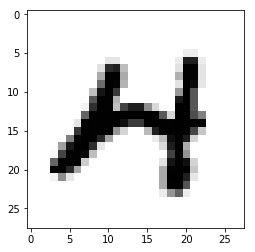

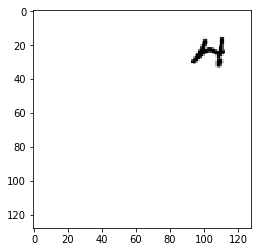

In [10]:
# Affiche le stimulus numéro i de la base de données, avant et après le reshape
i = 2
plt.imshow(mnist.train.images[i].reshape((28,28)), interpolation = 'nearest', cmap = 'gray_r')
plt.figure()
plt.imshow(mnist_reshape_128(mnist.train.images[i], i_offset = -40, j_offset = 40), interpolation = 'nearest', cmap = 'gray_r')

In [6]:
def calc_dim(shape, h, h_max): # calcule nombre d'ondelettes en fonction de l'echelle ? ; shape : taille image
    assert 0 <= h < h_max # h : echelle de composition d'ondelette
    if h == 0:
        dim_i = int(math.ceil(shape[0] * 1. // 2**(h_max - 1)))
        dim_j = int(math.ceil(shape[1] * 1. // 2**(h_max - 1)))
    else :
        dim_i = int(math.ceil(shape[0] * 1. // 2**(h_max - h)))
        dim_j = int(math.ceil(shape[1] * 1. // 2**(h_max - h)))
    return dim_i, dim_j

In [7]:
class WaveImage:
	
	def __init__(self, image = None, shape = (32, 32)):
		
		# Attribut shape
		if image is not None:
			# Decomposition ondelettes
			coeffs = pywt.wavedec2(image, 'haar') # haar correspond à une famille d'ondelettes
			self.__shape = image.shape
		else:
			self.__shape = shape
		
		# Attribut h_max : profondeur de l'image
		self.__h_max = min(int(math.log(self.__shape[0], 2)) + 1, 	int(math.log(self.__shape[1], 2)) + 1)
			
		# Attribut data : L'attribut data contient les vecteurs en position [h][u] (dictionnaire)
		if image is not None:
			self.__data = {}
			for h in range(self.__h_max):
				self.__data[h] = {}
				if h == 0:
					(i_max, j_max) = coeffs[h].shape
				else:
					(i_max, j_max) = coeffs[h][0].shape
				for i in range(i_max):
					for j in range(j_max):
						if h == 0:
							data = coeffs[h][i][j]
						else:
							data = coeffs[h][0][i][j] # k : num ondelette ?
							for k in range(1,len(coeffs[h])):
								data = np.append(data, coeffs[h][k][i][j])	
						self.__data[h][(i, j)] = data				
		else: # image is None
			self.__data = {}
			for h in range(self.__h_max):
				self.__data[h] = {}
					
		
	def get_data(self):
		return self.__data
	
	def get_shape(self):
		return self.__data
				
	def set_data(self, h, u, v):
		assert 0 <= h < self.__h_max
		dim_i, dim_j = calc_dim(self.__shape, h, self.__h_max)
		assert 0 <= u[0] < dim_i
		assert 0 <= u[1] < dim_j
		if h == 0 :
			self.__data[h][u] = v
		else:
			self.__data[h][u] = np.copy(v)
		
	def get_h_max(self):
		return self.__h_max
		
	def get_image(self): # etape decodage pour retrouver image
		coeffs = []
		for h in range(self.__h_max):
			dim_i, dim_j = calc_dim(self.__shape, h, self.__h_max)
			if h == 0:
				coeffs_h = np.zeros((dim_i, dim_j))
				for u in self.__data[h]:
					coeffs_h[u[0],u[1]] = self.__data[h][u]
			else:
				coeffs_h = [np.zeros((dim_i, dim_j)), np.zeros((dim_i, dim_j)), np.zeros((dim_i, dim_j))]
				for u in self.__data[h]:
					for k in range(3):
						coeffs_h[k][u[0],u[1]] = self.__data[h][u][k]
			coeffs += [coeffs_h]
		return pywt.waverec2(coeffs, 'haar')
		
	def add_coeffs(self, waveImage, u, h_ref = 0): # copie certains niveaux de l'arbre d'ondelettes
		# Niveau 0
		h_opp = self.__h_max - 1
		i = int(u[0] // 2**h_opp) 
		j = int(u[1] // 2**h_opp)
		u_0 = (i,j)
		if self.__data[0] == {}:
			self.__data[0][u_0] = waveImage.get_data()[0][u_0]
		else:
			v_test = self.__data[0][u_0]
			if np.linalg.norm(v_test) < 1e-16:
				self.__data[0][u_0] = waveImage.getData()[0][u_0]
		# Niveaux 1 et +
		for h in range(1, h_ref) :
			h_opp = self.__h_max - h
			i = int(u[0] // 2**h_opp) 
			j = int(u[1] // 2**h_opp)
			if (i,j) in self.__data[h]:
				v_test = self.__data[h][(i,j)]
				if np.linalg.norm(v_test) < 1e-16:
					self.__data[h][(i,j)] = np.copy(waveImage.get_data()[h][(i,j)])
			else: 
				self.__data[h][(i,j)] = np.copy(waveImage.get_data()[h][(i,j)])
	
	def copy(self): # copie complete
		self_shape = self.__shape 
		self_copy = WaveImage(shape = self_shape)
		for h in range(self.__h_max) :
			for u in self.__data[h]:
				self_copy.set_data(h, u, self.__data[h][u])
		return self_copy	
		
	def __str__(self): # affiche contenu objet
		h_max = len(self.__data)
		s = 'h_max :' + str(self.__h_max) + '\n'
		for h in range(self.__h_max):
			s += '***' + str(h) + '***\n'
			s += str(self.__data[h]) + '\n'
		return s

In [13]:
w1 = WaveImage(shape = (128, 128))
w2 = WaveImage(image = mnist_reshape_128(mnist.train.images[1], i_offset = 5, j_offset = 5))
w1.add_coeffs(w2, u = (63, 63), h_ref = w2.get_h_max())
w1.add_coeffs(w2, u = (63, 65), h_ref = w2.get_h_max())
w1.add_coeffs(w2, u = (65, 63), h_ref = w2.get_h_max())
w1.add_coeffs(w2, u = (65, 65), h_ref = w2.get_h_max())

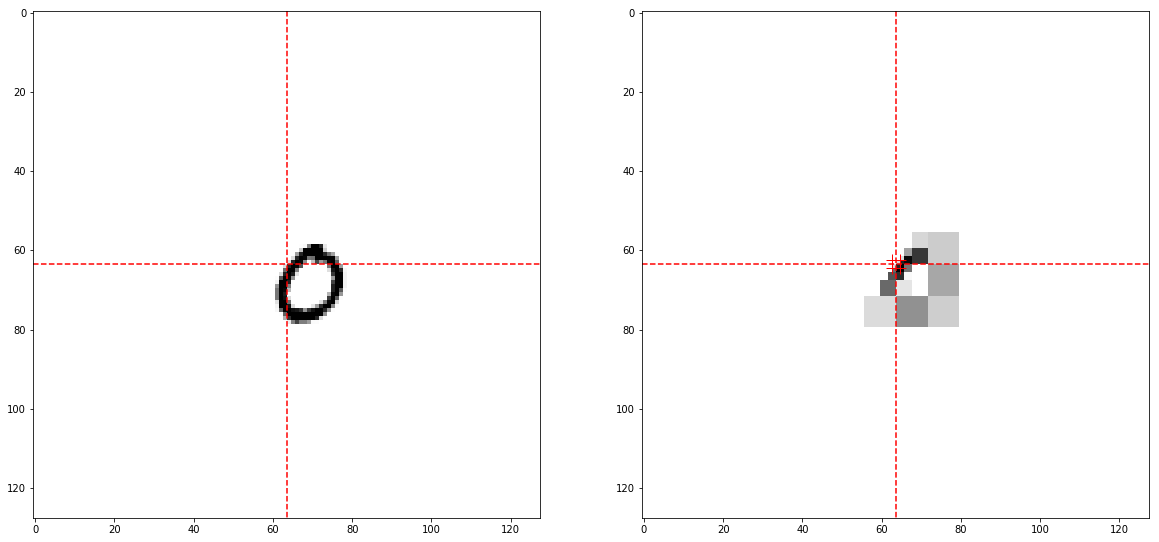

In [14]:
plt.figure(figsize = (20,20))
plt.subplot(1,2,1)
plt.imshow(w2.get_image(), cmap = 'gray_r', interpolation = 'nearest')
plt.plot([-0.5, 127.5],[63.5, 63.5],'r--')
plt.plot([63.5, 63.5],[-0.5, 127.5],'r--')
plt.xlim([-0.5, 127.5])
plt.ylim([-0.5, 127.5])
plt.gca().invert_yaxis()
plt.subplot(1,2,2)
plt.imshow(w1.get_image(), cmap = 'gray_r', interpolation = 'nearest')
plt.plot([-0.5, 127.5],[63.5, 63.5],'r--')
plt.plot([63.5, 63.5],[-0.5, 127.5],'r--')
plt.plot(63 - .5, 63 - .5, 'r+', markersize = 12)
plt.plot(63 - .5, 65 - .5, 'r+', markersize = 12)
plt.plot(65 - .5, 63 - .5, 'r+', markersize = 12)
plt.plot(65 - .5, 65 - .5, 'r+', markersize = 12)
plt.xlim([-0.5, 127.5])
plt.ylim([-0.5, 127.5])
plt.gca().invert_yaxis()

In [8]:
# Genere un dictionnaire de tenseurs indexes par la profondeur dans l'arbre des coefficients d'ondelettes 
def generate_tensor_data_with_offset_from_x(x, i_offset, j_offset):
    w1 = WaveImage(shape = (128, 128))
    w2 = WaveImage(image = mnist_reshape_128(x, i_offset = i_offset, j_offset = j_offset))
    w1.add_coeffs(w2, u = (63, 63), h_ref = w2.get_h_max())
    w1.add_coeffs(w2, u = (63, 65), h_ref = w2.get_h_max())
    w1.add_coeffs(w2, u = (65, 63), h_ref = w2.get_h_max())
    w1.add_coeffs(w2, u = (65, 65), h_ref = w2.get_h_max())
    h_max = w1.get_h_max()
    data = w1.get_data()
    tensor_data = {}
    for k in data :
        if k == 0:
            tensor_data[0] = data[k][(0, 0)]
        elif k == 1:
            tensor_data[1] = np.array(data[k][(0, 0)])    
        else:
            tensor_data[k] = np.zeros((2, 2, 3))
            for u in data[k]:           
                u_offset = 64 // (2**(h_max - k)) - 1
                tensor_data[k][u[0] - u_offset, u[1] - u_offset, :] = np.array(data[k][u])
    return tensor_data, w1

In [9]:
def generate_vector_data_with_offset_from_x(x, i_offset, j_offset):
    # retourne un vecteur contenant les coefficients utilisés de l'image w1 générée à partir d'un point de fixation
    # central avec la cible en position i_offset, j_offset
    w1 = WaveImage(shape = (128, 128))
    w2 = WaveImage(image = mnist_reshape_128(x, i_offset = i_offset, j_offset = j_offset))
    w1.add_coeffs(w2, u = (63, 63), h_ref = w2.get_h_max())
    w1.add_coeffs(w2, u = (63, 65), h_ref = w2.get_h_max())
    w1.add_coeffs(w2, u = (65, 63), h_ref = w2.get_h_max())
    w1.add_coeffs(w2, u = (65, 65), h_ref = w2.get_h_max())
    h_max = w1.get_h_max() # h = 7
    data = w1.get_data()
    vector_data = np.array([])
    for k in data :
        if k == 0:
            vector_data = np.append(vector_data, [data[k][(0, 0)]])
        elif k == 1:
            vector_data = np.append(vector_data, data[k][(0, 0)])  
        else:
            for u in data[k]:           
                 vector_data = np.append(vector_data, data[k][u])
    return vector_data, w1

v = 
 [ 0.92579662 -0.74497553 -0.50024513  0.31942404 -0.18082109  0.18082109
 -0.18082109  0.4255515  -0.4255515  -0.4255515   0.          0.          0.
  1.24522066  1.24522066  1.24522066 -0.36164218  0.36164218 -0.36164218
  0.          0.          0.          0.85110299 -0.85110299 -0.85110299
  2.49044133  2.49044133  2.49044133  2.63970605 -0.78333337  1.53333343
 -0.72328436 -0.10857844  0.10857844  0.          0.          0.
 -0.24436275 -1.70220598  0.24436275 -0.90196085  1.41666674  0.68627455
 -0.61470592  0.61470592 -0.61470592  0.          0.          0.
 -1.01568634 -1.45784323  1.01568634  0.07549021  1.0205883  -0.31470592
 -1.12745105 -0.04901961  0.04901961  0.          0.          0.
 -0.31862747 -0.44215689  0.31862747 -0.16862747 -0.24313727 -0.17254904
 -0.19215686 -0.682353   -0.02745099  0.          0.          0.
 -0.12352942 -0.12352942  0.12352942]
w = 
 h_max :8
***0***
{(0, 0): 0.92579662447678956}
***1***
{(0, 0): array([-0.74497553, -0.50024513,  0.31

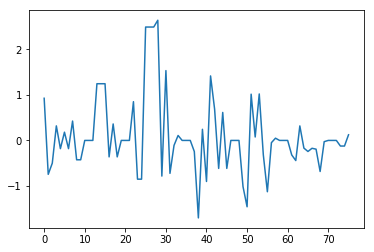

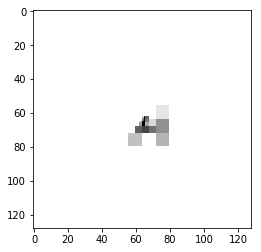

In [17]:
x = mnist.train.images[2] 
i_offset = 5
j_offset = 5
v, w = generate_vector_data_with_offset_from_x(x, i_offset, j_offset) ; print('v = \n', v)
plt.figure()
plt.plot(v)
plt.figure()
plt.imshow(w.get_image(), cmap = 'gray_r', interpolation = 'nearest') ; print('w = \n', w)

In [10]:
def generate_pow3_one_hot_coordinates_from_offset(i_offset, j_offset):
    # i_offset, j_offset in -40,..,40
    
    assert -40 <= i_offset <= 40
    assert -40 <= j_offset <= 40

    pow3_i = np.zeros(4)
    reste = 40 + i_offset
    for pow in range(3,-1,-1):
        pow3_i[pow] = reste // 3**pow - 1
        reste = reste % 3**pow
        
    pow3_j = np.zeros(4)
    reste = 40 + j_offset
    for pow in range(3,-1,-1):
        pow3_j[pow] = reste // 3**pow - 1
        reste = reste % 3**pow
    
    pow3_one_hot = []
    for pow in range(4):
        tmp = np.zeros((3,3))
        tmp[int(pow3_i[pow]) + 1, int(pow3_j[pow]) + 1] = 1
        pow3_one_hot += [tmp.reshape(9,)]
    return pow3_one_hot

In [19]:
# encode coordonnees sous forme de vecteurs representant codage en puissance de trois des coordonnees 
y = generate_pow3_one_hot_coordinates_from_offset(i_offset, j_offset)
print(y)

[array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]), array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.])]


In [11]:
def decode_from_pow3_one_hot(pow3_one_hot):
    i_offset = 0
    j_offset = 0
    for pow in range(len(pow3_one_hot)):
        tmp = pow3_one_hot[pow].reshape(3,3)
        i_tmp, j_tmp = np.where(tmp == 1)
        i_offset += (i_tmp[0] - 1) * 3**pow 
        j_offset += (j_tmp[0] - 1) * 3**pow
    return i_offset, j_offset

## Tests

In [21]:
print("(i,j) =",decode_from_pow3_one_hot(y))

(i,j) = (5, 5)


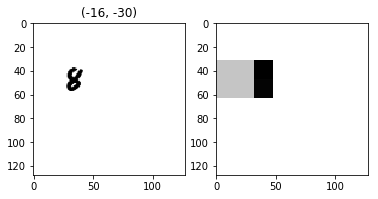

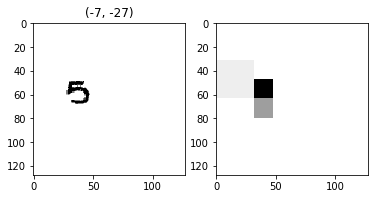

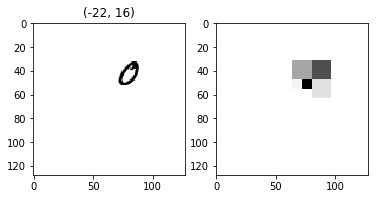

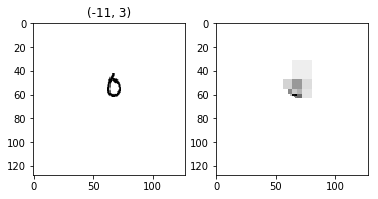

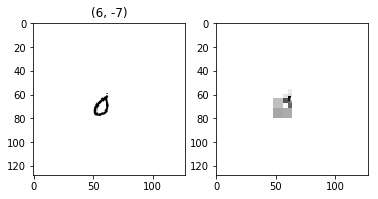

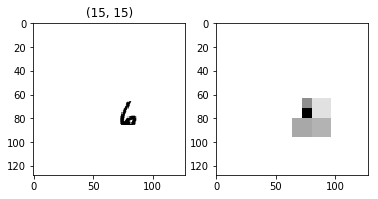

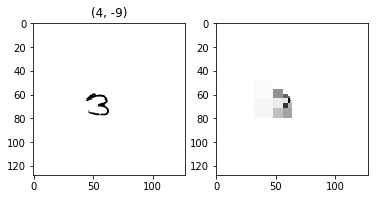

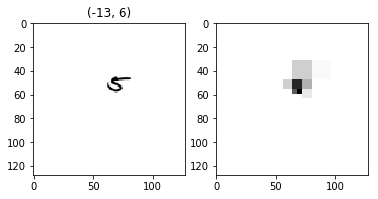

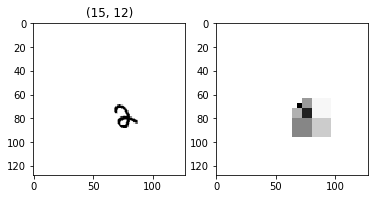

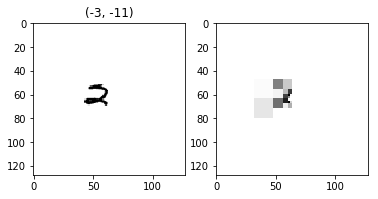

In [12]:
# Main program
BATCH_SIZE = 10
batch = mnist.train.next_batch(BATCH_SIZE)
data = []
for x in batch[0]:
    #i_offset = np.random.randint(0,81) - 40
    #j_offset = np.random.randint(0,81) - 40
    i_offset = int(np.random.randn() * 15)
    i_offset = max(i_offset, -40)
    i_offset = min(i_offset, 40)
    j_offset = int(np.random.randn() * 15)  
    j_offset = max(j_offset, -40)
    j_offset = min(j_offset, 40)
    v, w = generate_vector_data_with_offset_from_x(x, i_offset, j_offset)
    y = generate_pow3_one_hot_coordinates_from_offset(i_offset, j_offset)
    data += [(v,y)]
    
    # Visualisation
    plt.figure()
    plt.subplot(1,2,1)
    w_ref = WaveImage(image = mnist_reshape_128(x, i_offset = i_offset, j_offset = j_offset))
    plt.imshow(w_ref.get_image(), cmap = 'gray_r', interpolation = 'nearest')
    plt.title((i_offset, j_offset))
    plt.subplot(1,2,2)
    plt.imshow(w.get_image(), cmap = 'gray_r', interpolation = 'nearest')

In [23]:
for i, d in enumerate(data):
    print('i =',i) # Numero de l'exemple dans l'echantillon
    print("d[0] = ",d[0]) # Valeurs individuelles pixels
    print("d[1] = ",d[1]) # Valeurs vecteurs pow3 one hot
    print('*' * 100)      # Separateur visuel

i = 0
d[0] =  [ 0.61397063 -0.61397063  0.61397063 -0.61397063  0.          0.          0.
  1.22794125 -1.22794125 -1.22794125  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.         -0.42401964 -2.45588251  0.42401964  0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -0.99950986  0.58774514 -0.43480395  0.          0.
  0.          0.          0.          0.          0.          0.          0.
 -0.43970591  0.43970591 -0.43970591  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
d[1] =  [array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]), array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), array([ 1.,  0.,  0.,  0.

## Intégration d'une régression linéaire
Code en construction.  
Les commentaires ne contiennent pas d'accents pour éviter les problèmes de compatibilité lors de l'utilisation par des systèmes non-utf8.

In [156]:
def minmax(value,   #valeur a delimiter
           border): #limite min/max a ne pas depasser 
    value = max(value, -border)
    value = min(value, border)
    return value

def linear_regression_train(batch_size, # taille de l'echantillon d'apprentissage
                            alpha,      # parametre d'apprentissage ; un futur benchmark permettra de choisir une valeur optimale
                            theta,      # comprends (theta_y0,theta_y1), parametres modifies par l'apprentissage
                            iteration   # numero de l'iteration en cours
                            ):
    ### Recuperation des donnees pour l'apprentissage
    batch = mnist.train.next_batch(batch_size)
    data = []
    y = []

    for x in batch[0]:
        # i, j correspondent aux coordonnees reelles de la cible, comprises dans l'intervalle (-40,40)
        i_offset, j_offset = minmax(int(np.random.randn() * 15), 40), minmax(int(np.random.randn() * 15), 40)  
        v, w = generate_vector_data_with_offset_from_x(x, i_offset, j_offset) # v: vector, utilise comme x
        y = (i_offset,j_offset)
        data += [(v,y)]

    ### Realisation de la regression lineaire

    ## Initialisation des variables
    n = v.size                                            # nombre de valeurs comprises dans v
    if iteration == 0:                                    # si aucune iteration n'a ete realisee, generer les parametres au hasard
        theta_y0, theta_y1 = np.random.randn(n)*0.1, np.random.randn(n)*0.1             # un theta pour chaque valeur de v (~70)
    elif iteration != 0: 
        theta_y0, theta_y1 = theta[0], theta[1]
    hypo_y0, hypo_y1 = [[] for _ in range(batch_size)], [[] for _ in range(batch_size)] # hypotheses, pour le calcul du gradient descent
    Err_y0, Err_y1 = [], []                               # erreurs, pour le calcul du gradient descent
    sqrErr_y0, sqrErr_y1 = 0, 0                         # erreurs carrees, pour le calcul du cout
    delta_theta0, delta_theta1 = np.zeros(n), np.zeros(n) # valeur a soustraire a theta pour calculer theta(temps+1)                                    

    for m in range(batch_size):
        ## Calcul hypotheses
        hypo_y0[m] = np.dot(theta_y0,data[m][0])
        hypo_y1[m] = np.dot(theta_y1,data[m][0])

        ## Calcul erreurs
        Err_y0 += [(hypo_y0[m] - data[m][1][0])]
        Err_y1 += [(hypo_y1[m] - data[m][1][1])]

        ## Calcul gradient descent
        delta_theta0 += alpha*(1/batch_size)*Err_y0[m] * data[m][0]
        delta_theta1 += alpha*(1/batch_size)*Err_y1[m] * data[m][0]
        
    ## Mise à jour des parametres thetas
    theta_y0 -= delta_theta0
    theta_y1 -= delta_theta1
    
    ## Calcul erreurs carrees
    for i in Err_y0:
        sqrErr_y0 += i**2
    for j in Err_y1:
        sqrErr_y1 += j**2
    
    ## Calcul couts
    J_y0 = (1/2*batch_size)*sqrErr_y0
    J_y1 = (1/2*batch_size)*sqrErr_y1
    
    return (theta_y0, theta_y1, J_y0, J_y1)

In [155]:
values = (0,0) #initialisation des theta pour la premiere iteration
for num_iteration in range(10):
    theta_updated = linear_regression_train(batch_size=10, alpha=0.03, theta=values, iteration=num_iteration)
    values = (theta_updated[0], theta_updated[1])
    couts = (theta_updated[2], theta_updated[3])
    
    if num_iteration == 1:
        print('theta_y0 initial = \n', values[0])
        print('theta_y1 initial = \n', values[1])

print('\n Nouvelles valeurs après iteration #', num_iteration)
print('theta_y0 = \n', theta_updated[0])
print('theta_y1 = \n', theta_updated[1])

J_y0 = 6944.08610659
J_y1 = 6969.70506508
J_y0 = 10112.9155981
J_y1 = 10812.2326645
theta_y0 initial = 
 [  9.76869458e-02  -4.86327738e-01  -2.20465110e-02  -4.18396393e-02
  -1.04232932e-02  -1.69641877e-01   9.77253875e-02   9.44215144e-02
  -1.76091160e-01  -3.43113412e-01   3.13331854e-01   5.52816087e-01
  -4.34635953e-01   3.18568792e-01   1.44537413e-01   2.45103544e-01
  -9.11607799e-02  -3.36177528e-01   4.15657824e-02  -1.04162348e-01
   7.92001152e-01   2.24161772e-01   4.24941077e-03  -1.70359389e-02
  -5.53116465e-02   1.34300276e-02  -1.27885264e-01  -7.45758999e-02
  -2.21638362e-01  -8.45210943e-02  -3.00708018e-02  -2.01731100e-01
  -6.91633455e-02  -1.11065086e-01  -4.03128475e-01  -1.08124224e-01
   9.09862496e-03   9.61203700e-03   1.82112826e-01  -1.78457295e-03
  -2.58736019e-01   6.17052123e-03  -1.67193794e-02  -2.08704407e-01
  -1.20512084e-01   7.47498277e-02  -1.50546339e-01  -9.87451940e-02
   4.65961571e-02  -2.71193619e-01  -2.07062709e-04  -6.54449566e-0